In [9]:
%matplotlib inline
import numpy as np
import numpy.linalg as la
import scipy.linalg as sla
import matplotlib.pyplot as plt

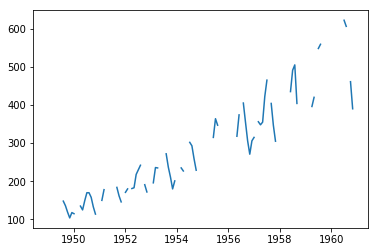

In [2]:
M=4
flights = np.genfromtxt('flights.csv', skip_header=1, delimiter=',')
time, x_orig = flights.T
plt.plot(time,x_orig)

In [55]:
def linear_interpolation(x, mis_index):
    '''
    This method estimates the missing values considering previous
    and next non-NaN values ie. with linear interpolation and return 
    new interpolated data.
    
    x: vector of real values
    mis_index: a vector of boolean values where the missing indexes are true.
    '''
    x = x.copy()
    min_val = np.min(x[~mis_index])
    max_val = np.max(x[~mis_index])
    
    flag = False;
    beg = -1
    end = len(x)
    for i in range(0,len(x)):
        if not flag and mis_index[i]:
            flag = True
            beg = i-1
        elif flag and not mis_index[i]:
            end = i
            flag = False
            values = np.linspace(x[beg], x[end], end-beg+1)
            x[beg+1:end] = values[1:-1]
            
    if flag:
        end = len(x)
        values = np.linspace(x[beg],max_val, end-beg+1)
        x[beg+1:end] = values[1:-1]
    return x

In [56]:
# print(np.isnan(x_orig))
mis_index = np.isnan(x_orig)
x_int = linear_interpolation(x_orig,mis_index)
x_cur = np.array([x_int]).T

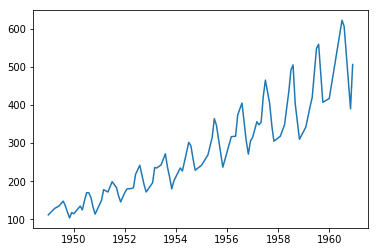

In [57]:
plt.plot(time,x_cur)

In [58]:
def get_gx(x_cur):
    '''
    Gets current x vector and return Gx matrix
    
    x_cur: vector of real numbers.
    '''
    gx = []
    x = x_cur
    for i in range(M, x.shape[0]):
        v = x[i-M:i , 0]
        v = v[::-1].T
        gx.append(v)
    gx = np.array(gx)
    b = x[M:]
    return (gx,b)

def get_ga(A, size):
    '''
    Gets current A vector and data size and returns Ga matrix
    
    A: vector of real numbers.
    size: dimension of x vector or ie. length of data
    '''
    ga = np.zeros([size-M,size])
    for i in range(0, size-M):
        ga[i, i:i+M] = np.fliplr(np.copy(A.T))
        ga[i, i+M] = -1
    return ga

In [59]:
def get_obs_mis(x_cur):
    '''
    Gets current x vector and returns observed x and missing x.
    
    x_cur: vector of real numbers.
    '''
    x_obs = x_cur.copy()
    x_mis = x_cur.copy()
    x_obs[mis_index]=0
    x_mis[~mis_index]=0
    return (x_obs, x_mis)

In [60]:
threshold = 1e-15
diff = 1
prev_A = np.array([0,0,0,0])

# iterates until differences are smaller than threshold.
while diff > threshold:

    #least square by fixing x
    Gx,b = get_gx(x_cur);
    Q, R = la.qr(Gx)
    tmp = np.matmul(Q.T,b)
    A = sla.solve_triangular(R,tmp)
    diff = la.norm(A-prev_A)
    prev_A = A

    #least square by fixing A
    x_obs, x_mis = get_obs_mis(x_cur)
    
    Ga = get_ga(A, x_cur.shape[0])
    Ga_obs = Ga[:, ~mis_index]
    Ga_mis = Ga[:, mis_index]
    b = -np.matmul(Ga_obs,x_obs[~mis_index,:])
    
    Q, R = la.qr(Ga_mis)
    tmp = np.matmul(Q.T,b)
    x_mis_new = sla.solve_triangular(R,tmp)
    
    x_prev = x_cur.copy()
    x_cur[mis_index, :] = x_mis_new

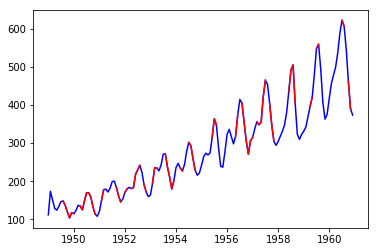

In [61]:
plt.plot(time, x_cur, color="blue")

x_obss = x_cur.copy()
x_obss[~mis_index] = np.nan
plt.plot(time, x_orig, color="red")

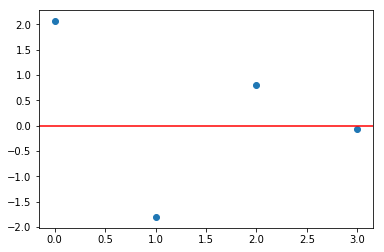

In [54]:
plt.axhline(0, color='red')
plt.scatter(range(A.shape[0]),A)